In [59]:
import cv2
import numpy as np
import os
import yaml
from yaml.loader import SafeLoader
import matplotlib.pyplot as plt

In [8]:
#Load YAML
with open('data.yaml', mode='r') as f:
    data_yaml = yaml.load(f, Loader=SafeLoader)

labels = data_yaml['names']
print(labels)

['person', 'car', 'chair', 'bottle', 'pottedplant', 'bird', 'dog', 'sofa', 'bicycle', 'horse', 'boat', 'motorbike', 'cat', 'tvmonitor', 'cow', 'sheep', 'aeroplane', 'train', 'diningtable', 'bus']


In [9]:
#Load YOLO model
yolo = cv2.dnn.readNetFromONNX('./Model/weights/best.onnx')
yolo.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
yolo.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

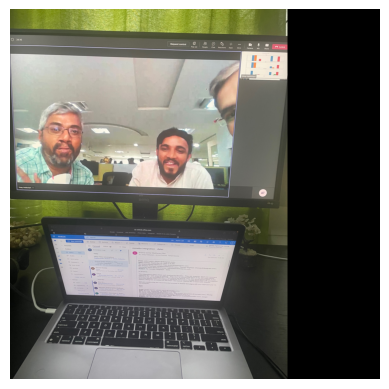

In [37]:
img = cv2.imread('./Office_Image.jpeg')
image = img.copy()
row, col, d = image.shape

#getting yolo prediction from the image

#step-1: convert image into square image
max_rc = max(row, col)
input_image = np.zeros((max_rc, max_rc, 3), dtype=np.uint8)
input_image[0:row, 0:col] = image

INPUT_WH_YOLO = 640

#step-2: get predictions
blob = cv2.dnn.blobFromImage(input_image, 1/255, (INPUT_WH_YOLO, INPUT_WH_YOLO), swapRB=True, crop=False)
yolo.setInput(blob)
preds = yolo.forward() 

plt.imshow(cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB))
plt.axis('off')  # Optional, to hide the axis
plt.show()

# cv2.imshow('input_image', input_image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()
# cv2.waitKey(1)

In [38]:
print(preds.shape)

(1, 25200, 25)


In [39]:
# Non-Max Suppression

#step1: filter detection based on confidence score (0.4), and probability score (0.25)
detections = preds[0]
boxes, confidences, classes = [], [], []

image_w, image_h = input_image.shape[:2]
x_factor = image_w/INPUT_WH_YOLO
y_factor = image_h/INPUT_WH_YOLO

for i in range(len(detections)):
    row = detections[i]
    confidence = row[4]
    if confidence > 0.4:
        class_score = row[5:].max()
        class_id = row[5:].argmax()
        if class_score > 0.25:
            cx,cy,w,h = row[0:4]
            #construction of bounding box
            left = int((cx - 0.5*w)*x_factor)
            top = int((cy - 0.5*h)*y_factor)
            width = int(w*x_factor)
            height = int(h*y_factor)

            box = np.array([left, top, width, height])
            confidences.append(confidence)
            boxes.append(box)
            classes.append(class_id)


boxes_np = np.array(boxes).tolist()
confidences_np = np.array(confidences).tolist()

#NMS
index = cv2.dnn.NMSBoxes(boxes_np, confidences_np, 0.25, 0.4).flatten()

In [40]:
index

array([ 8, 12,  9], dtype=int32)

In [57]:
#Draw the bounding boxes
for ind in index:
    x,y,w,h = boxes_np[ind]
    bb_conf = confidences_np[ind]
    classes_id = classes[ind]
    class_name = labels[classes_id]

    text = f'{class_name}: {bb_conf}%'
    cv2.rectangle(image, (x,y), (x+w, y+h), (0,255,0), 3)
    cv2.rectangle(image, (x,y-40), (x+w,y), (255,255,255), -1)
    cv2.putText(image, text, (x,y-10), cv2.FONT_HERSHEY_PLAIN, 3, (0,0,0), 2)

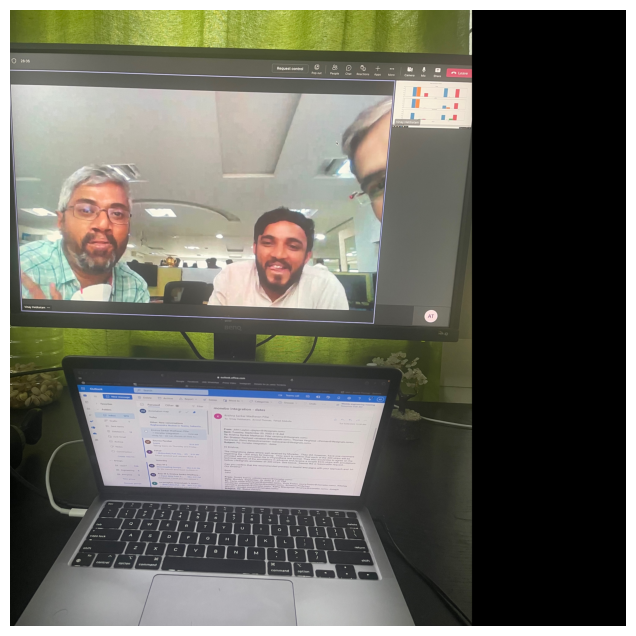

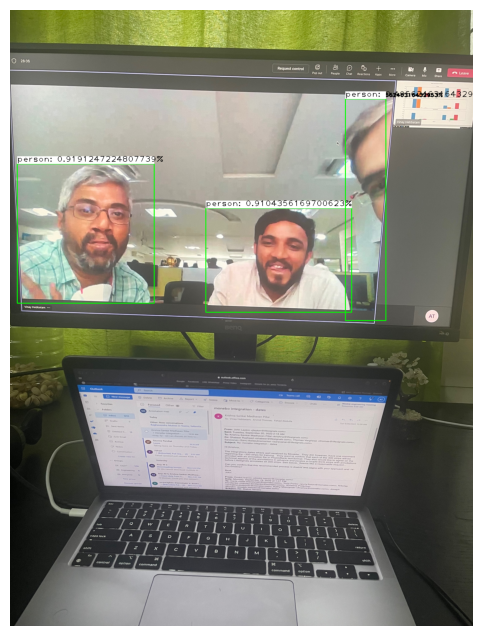

In [58]:
plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB))
plt.axis('off')  # Optional, to hide the axis
plt.show()

plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')  # Optional, to hide the axis
plt.savefig('office_image_prediction.png')
plt.show()